In [1]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import matplotlib.collections as clt
import matplotlib.patches as mpatches
import pickle


In [2]:
# import medians
medians = pd.read_csv('../results/country_median_results.csv')
medians.loc[medians['Entity'] == 'Global', 'region'] = 'Global'

# calculate unpiped pop by region
medians["NAT_unpiped"] = 100 - medians["NATPiped"]
medians["population_unpiped"] = medians["country_pop_raw"] * medians["NAT_unpiped"] / 100

# calculate global pop unpiped as sum of all rows except global
medians.loc[medians['Entity'] == 'Global', 'population_unpiped'] = medians.loc[medians['Entity'] != 'Global', 'population_unpiped'].sum()

# calculate region data
medians_unpiped = medians.groupby('region').apply(lambda x: x['population_unpiped'].sum() / x['country_pop_raw'].sum() * 100)
medians_no_access = medians.groupby('region').apply(lambda x: x['country_pop_without_water'].sum() / x['country_pop_raw'].sum() * 100)
medians_walk_access = medians.groupby('region').apply(lambda x: x['population_piped_with_walking_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_bike_access = medians.groupby('region').apply(lambda x: x['population_piped_with_only_cycling_access'].sum() / x['country_pop_raw'].sum() * 100)
medians_undefined = 100 - medians_no_access - medians_walk_access - medians_bike_access - medians_unpiped

medians_regions = pd.DataFrame(
    {
        'region': medians_no_access.index,
        'no_access': medians_no_access.values,
        'walk_access': medians_walk_access.values,
        'bike_access': medians_bike_access.values,
        'unpiped': medians_unpiped.values,
        'undefined': medians_undefined.values,
    }
)

# set index to regions
medians_regions.set_index('region', inplace=True)

order = ['Oceania', 'Asia', 'Africa', 'Global', 'Europe', 'Americas']
medians_regions = medians_regions.reindex(order)

medians_regions


,no_access,walk_access,bike_access,unpiped,undefined
region,,,,,
Oceania,17.525905,42.892747,14.959185,20.962769,3.659394
Asia,20.120619,27.886671,13.328865,37.841870,0.821976
Africa,22.288981,14.027505,3.331195,54.586874,5.765445
Global,23.028945,28.300155,13.219295,33.231946,2.219659
Europe,23.061363,47.587616,20.563000,5.374360,3.413661
Americas,36.666757,33.060750,20.239172,4.611088,5.422232


In [3]:
# import medians and CIs for no access
# Read country-level results from Monte Carlo sims
country_medians = pd.read_csv("../results/country_median_results.csv")
country_means = pd.read_csv("../results/country_mean_results.csv")
country_5th_percentiles = pd.read_csv("../results/country_5th_percentile_results.csv")
country_95th_percentiles = pd.read_csv("../results/country_95th_percentile_results.csv")

# Define a function to calculate percent without water
def calculate_percent(df, group):
    df.loc[df['Entity'] == 'Global', 'region'] = 'Global'
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})


# Print results
print(region_percent_without_water.sort_values(by='median', ascending=False))

             median  5th_percentile  95th_percentile
region                                              
Americas  36.666757       24.485413        50.360961
Europe    23.061363       10.941837        38.306181
Global    23.028945       14.399294        32.970732
Africa    22.288981       15.517477        29.501465
Asia      20.120619       12.260690        29.691903
Oceania   17.525905        8.916453        30.022932


In [4]:
with open('../results/countries_simulation_results.pkl', 'rb') as f:
    results = pickle.load(f)

for df in results:
    df.loc[df['Entity'] == 'Global', 'region'] = 'Global'

# region_total_access = [
#     df.groupby('region').apply(lambda x: x['country_pop_with_water'].sum() / x['country_pop_raw'].sum() * 100)
#     for df in results
# ]

region_walk_access = [
    df.groupby('region').apply(lambda x: x['population_piped_with_walking_access'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_no_access = [
    df.groupby('region').apply(lambda x: x['country_pop_without_water'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

region_bike_access = [
    df.groupby('region').apply(lambda x: x['population_piped_with_only_cycling_access'].sum() / x['country_pop_raw'].sum() * 100)
    for df in results
]

# region_unpiped = [
#     df.groupby('region').apply(lambda x: x['country_pop_with_water'].sum() - x["population_piped_with_access"].sum() / x['country_pop_raw'].sum() * 100)
#     for df in results
# ]

# Create list of DataFrames with the results
region_dfs = [
    pd.DataFrame({
        'region': no_access_df.index,
        # 'total_access': total_access_df.values,
        'no_access': no_access_df.values,
        'walk_access': walk_access_df.values,
        'bike_access': bike_access_df.values,
        # 'unpiped': unpiped_df.values,
    })
    for no_access_df, walk_access_df, bike_access_df in zip(region_no_access, region_walk_access, region_bike_access)
]

region_dfs


[     region  no_access  walk_access  bike_access
 0    Africa  28.326310     8.147735     3.153403
 1  Americas  51.881204    19.997734    18.401171
 2      Asia  29.703942    17.696134    14.148749
 3    Europe  38.981301    28.796933    23.543235
 4    Global  33.245799    17.447013    13.699839
 5   Oceania  27.688939    29.931364    18.828487,
      region  no_access  walk_access  bike_access
 0    Africa  28.701324     6.750660     4.175463
 1  Americas  48.273751    16.983533    25.022825
 2      Asia  28.689864    13.372696    19.471838
 3    Europe  34.015292    26.420751    30.885426
 4    Global  31.787766    13.970996    18.633889
 5   Oceania  29.008147    22.178857    25.261786,
      region  no_access  walk_access  bike_access
 0    Africa  26.418206     9.405549     3.803692
 1  Americas  43.431108    24.702132    22.146869
 2      Asia  25.090761    20.364009    16.079629
 3    Europe  29.897790    35.080984    26.342695
 4    Global  28.206468    20.460314    15.72586

In [5]:
df = pd.concat(region_dfs, ignore_index=True)
df

,region,no_access,walk_access,bike_access
0,Africa,28.326310,8.147735,3.153403
1,Americas,51.881204,19.997734,18.401171
2,Asia,29.703942,17.696134,14.148749
3,Europe,38.981301,28.796933,23.543235
4,Global,33.245799,17.447013,13.699839
...,...,...,...,...
5995,Americas,41.414409,33.987217,14.878483
5996,Asia,21.820091,29.116537,10.597770
5997,Europe,25.073349,49.192308,17.055811
5998,Global,24.862754,29.180831,10.349066


In [6]:
# melt the DataFrame
df_melt = pd.melt(df, id_vars=['region'], value_vars=['no_access', 'walk_access', 'bike_access'])
df_melt

no_access = df_melt[df_melt['variable'] == 'no_access']
no_access

,region,variable,value
0,Africa,no_access,28.326310
1,Americas,no_access,51.881204
2,Asia,no_access,29.703942
3,Europe,no_access,38.981301
4,Global,no_access,33.245799
...,...,...,...
5995,Americas,no_access,41.414409
5996,Asia,no_access,21.820091
5997,Europe,no_access,25.073349
5998,Global,no_access,24.862754


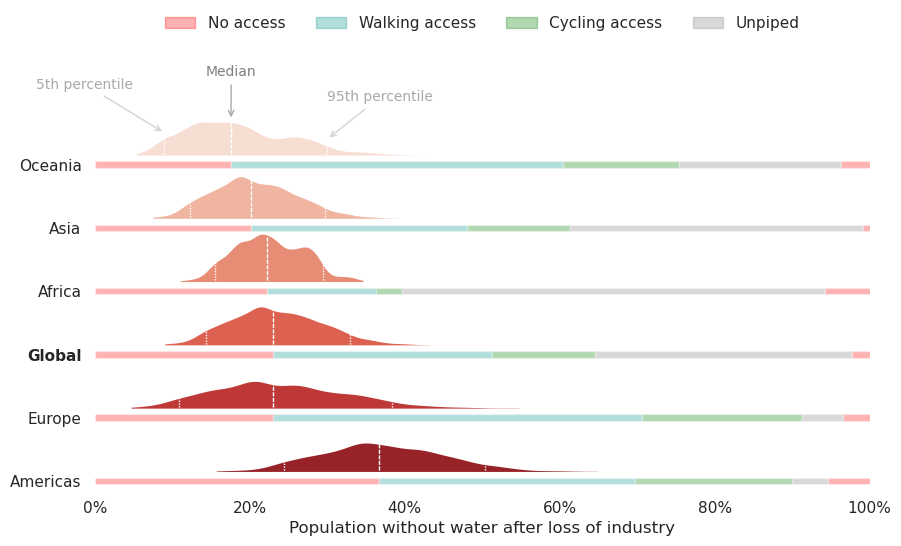

In [7]:
# plotting the clouds
# remove lines
sns.set(style="white")
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlim(0,100)
# ax.set_ylim(-1, len(medians_regions.index) + 3)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1 - 6 ,y2 + 7))


medians_regions = medians_regions.reindex(order)
medians_regions.plot.barh(
      stacked=True, 
      ax=ax, 
      alpha=0.3,
      width=0.1,
      legend=False,
      color=['red', '#009688', 'green', 'grey'],
    #   linewidth=0.5,
    #   edgecolor="black"
      )

dy="region"; dx="value"; ort="h"; pal = sns.color_palette(n_colors=5)

ax = pt.half_violinplot(
      x = dx,
      y = dy, 
      data = no_access,
      palette = "Reds",
    #   palette = "Reds",
      order=order,
      bw = .2, 
      cut = 0.,
      scale = "area",
      width = 1.5,
      inner = None,
      orient = ort,
      linewidth=0,
      # fix x axis 0-100
      )


# Extract the median and quantiles from region_percent_without_water
medians = region_percent_without_water['median']
quantile_5 = region_percent_without_water['5th_percentile']
quantile_95 = region_percent_without_water['95th_percentile']

# Add lines for the median and quantiles
violin_width = 0.7  # Adjust this value based on the width of your violin plots
shift = -0.5  # Adjust this value based on how much you want to shift the lines up
for i, region in enumerate(order):
    median = medians[region]
    q5 = quantile_5[region]
    q95 = quantile_95[region]
    ax.plot([median, median], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (3, 1)))
    ax.plot([q5, q5], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))
    ax.plot([q95, q95], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))

# Remove the box around the plot
for side in ['bottom', 'right', 'top', 'left']:
    ax.spines[side].set_visible(False)

# Add a horizontal line per region
# for y in range(len(medians_regions.index)):
#     ax.axhline(y + 0.05, color='grey', linestyle='-', alpha=1)

# Remove the "region" label
ax.set_ylabel('')
ax.set_xlabel('Population without water after loss of industry')

# legend
labels = ['No access', 'Walking access', 'Cycling access', 'Unpiped']  # Replace with your actual labels
colors = ['red', '#009688', 'green', 'grey']

# Create a list of patches for the legend
patches = [mpatches.Patch(color=color, label=label, alpha=0.3) for label, color in zip(labels, colors)]

# Add the legend to the top of the plot
ax.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(patches), frameon=False)

# Make the "Global" label bold
for label in ax.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels as percentages
def to_percent(x, position):
    return f'{int(x)}%'

# Create a formatter
formatter = FuncFormatter(to_percent)

# Set the formatter for the x-axis
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim(len(medians_regions.index) - 0.9, -2.2)

ax.annotate('Median', xy=(17.6, -0.7), xytext=(17.6, -1.4), size=10, 
            arrowprops=dict(arrowstyle='->', color="darkgrey"), ha='center', color="grey")

ax.annotate('5th percentile', xy=(9, -0.5), xytext=(5, -1.2), size=10, 
            arrowprops=dict(arrowstyle='->', color="lightgrey"), ha='right', color="darkgrey")

ax.annotate('95th percentile', xy=(30, -0.4), xytext=(30, -1), size=10, 
            arrowprops=dict(arrowstyle='->', color="lightgrey"), ha='left', color="darkgrey")

plt.show()


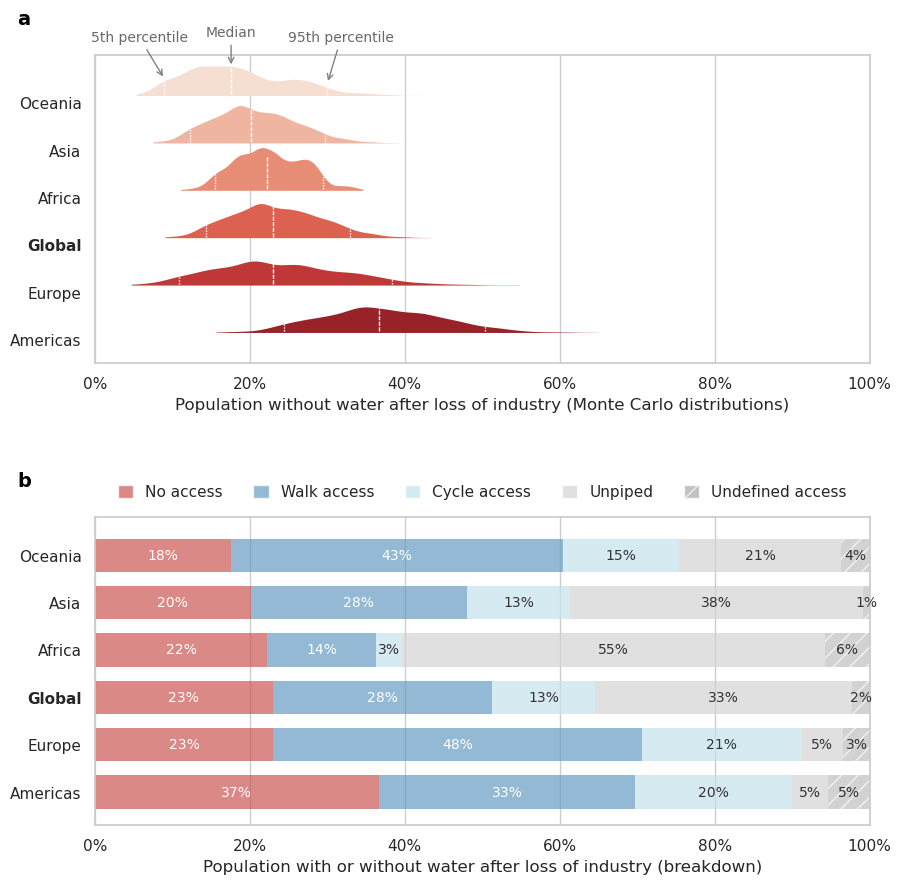

In [8]:
# plotting the clouds
# remove lines
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), sharex=False)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
# # ax.set_ylim(-1, len(medians_regions.index) + 3)
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,y1 - 6 ,y2 + 7))

############## TOP PLOT #####################

medians_regions = medians_regions.reindex(order)
bars = medians_regions.plot.barh(
      stacked=True, 
      ax=ax2, 
      alpha=0.7,
      width=0.7,
      legend=False,
    #   color=['firebrick', '#009688', 'mediumaquamarine', 'grey'],
    #   color=['#cb5754', '#659cc4', '#c5e2ec', '#feffab'],
      color=['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'silver'],
      linewidth=0,
      edgecolor='white',
      )

# Apply hatching to the last category
patterns = [''] * 24 + ['//'] * 6

for bar, pattern in zip(bars.patches, patterns):
     bar.set_hatch(pattern)


count=0
label_color = "white"
for container in ax2.containers:
    if count > 1:
        label_color = "#333333"
    ax2.bar_label(container, label_type="center", fmt="%.0f%%", fontsize=10, color=label_color)
    count += 1

############# BOTTOM PLOT ###################

dy="region"; dx="value"; ort="h"; pal = sns.color_palette(n_colors=5)

pt.half_violinplot(
    x = dx,
    y = dy, 
    data = no_access,
    ax=ax1,
    palette = "Reds",
    #   palette = "Reds",
    order=order,
    bw = .2, 
    cut = 0.,
    scale = "area",
    width = 1.8,
    inner = None,
    orient = ort,
    linewidth=0,
    # fix x axis 0-100
    )

# Extract the median and quantiles from region_percent_without_water
medians = region_percent_without_water['median']
quantile_5 = region_percent_without_water['5th_percentile']
quantile_95 = region_percent_without_water['95th_percentile']

# Add lines for the median and quantiles
violin_width = 0.7  # Adjust this value based on the width of your violin plots
shift = -0.5  # Adjust this value based on how much you want to shift the lines up
for i, region in enumerate(order):
    median = medians[region]
    q5 = quantile_5[region]
    q95 = quantile_95[region]
    ax1.plot([median, median], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (3, 1)))
    ax1.plot([q5, q5], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))
    ax1.plot([q95, q95], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=1, ls=(0, (1, 1)))

# Remove the box around the plot
for side in ['bottom', 'right', 'top', 'left']:
    ax.spines[side].set_visible(False)

# Remove the "region" label
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('Population without water after loss of industry (Monte Carlo distributions)')
ax2.set_xlabel('Population with or without water after loss of industry (breakdown)')

# Define the labels, colors, and hatches for the legend
labels = ['No access', 'Walk access', 'Cycle access', 'Unpiped', 'Undefined access']
colors = ['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey', 'darkgrey']
hatches = ['', '', '', '', '//']  # Add hatching to the last category

# Create a list of patches for the legend
patches = []
for label, color, hatch in zip(labels, colors, hatches):
    patch = mpatches.Patch(facecolor=color, edgecolor='white', hatch=hatch, label=label, alpha=0.7)
    patches.append(patch)

# Add the legend to the top of the plot
ax2.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(patches), frameon=False, handleheight=1.0, handlelength=1.0)


# Make the "Global" label bold
for label in ax1.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

for label in ax2.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels as percentages
def to_percent(x, position):
    return f'{int(x)}%'

# Create a formatter
formatter = FuncFormatter(to_percent)

# # Set the formatter for the x-axis
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim(len(medians_regions.index) - 0.5, -1)
ax2.set_ylim(len(medians_regions.index) - 0.3, -0.8)

plt.subplots_adjust(hspace=0.5)
ax2.yaxis.grid(False)

# Add labels to the subplots
ax1.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=14, weight='bold', color="black")
ax2.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=14, weight='bold', color="black")

ax1.annotate('Median', xy=(17.6, -0.75), xytext=(17.6, -1.4), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='center', color="dimgrey")

ax1.annotate('5th percentile', xy=(9, -0.5), xytext=(12, -1.3), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='right', color="dimgrey")

ax1.annotate('95th percentile', xy=(30, -0.4), xytext=(25, -1.3), size=10, 
            arrowprops=dict(arrowstyle='->', color="grey"), ha='left', color="dimgrey")

# save as 300 dpi png
plt.savefig('../results/access_distributions.png', dpi=300)
plt.show()


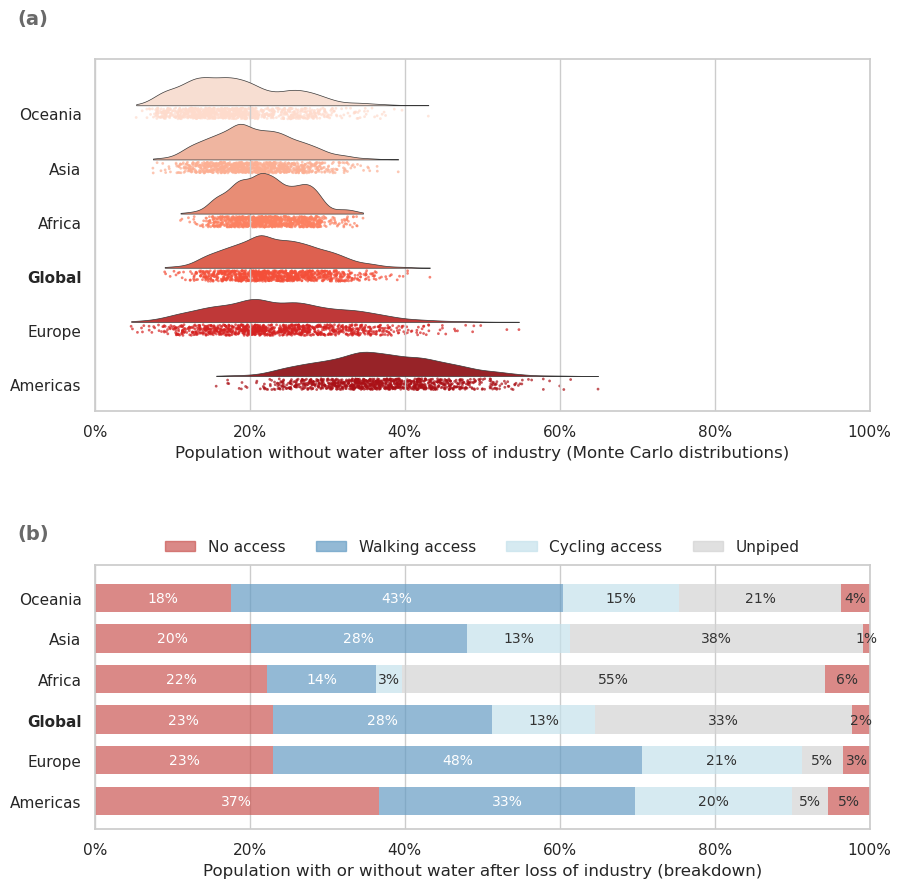

In [9]:
# plotting the clouds
# remove lines
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 3]}, sharex=False)
ax1.set_xlim(0, 100)
ax2.set_xlim(0, 100)

# # ax.set_ylim(-1, len(medians_regions.index) + 3)
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,y1 - 6 ,y2 + 7))

############## TOP PLOT #####################

medians_regions = medians_regions.reindex(order)
medians_regions.plot.barh(
      stacked=True, 
      ax=ax2, 
      alpha=0.7,
      width=0.7,
      legend=False,
    #   color=['firebrick', '#009688', 'mediumaquamarine', 'grey'],
    #   color=['#cb5754', '#659cc4', '#c5e2ec', '#feffab'],
      color=['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey'],
      linewidth=0,
      edgecolor='grey',
      )

count=0
label_color = "white"
for container in ax2.containers:
    if count > 1:
        label_color = "#333333"
    ax2.bar_label(container, label_type="center", fmt="%.0f%%", fontsize=10, color=label_color)
    count += 1

############# BOTTOM PLOT ###################

dy="region"; dx="value"; ort="h"; pal = sns.color_palette(n_colors=5)

pt.half_violinplot(
    x = dx,
    y = dy, 
    data = no_access,
    ax=ax1,
    palette = "Reds",
    #   palette = "Reds",
    order=order,
    bw = .2, 
    cut = 0.,
    scale = "area",
    width = 1.5,
    inner = None,
    orient = ort,
    linewidth=0.5,
    #fix x -100
    
    )

sns.stripplot(
    x=dx,
    y=dy,
    data=no_access,
    ax=ax1,
    palette="Reds",
    order=order,
    edgecolor="white",
    alpha=0.7,
    size=2,
    jitter=1,
    zorder=0,
    orient=ort
)

# # Calculate the median and confidence intervals
# medians = no_access.groupby(['region'])['value'].median()
# conf_ints = no_access.groupby(['region'])['value'].quantile([0.05, 0.95]).unstack()

# # Add lines for the median and confidence intervals
# violin_width = 0.7  # Adjust this value based on the width of your violin plots
# shift = -0.5  # Adjust this value based on how much you want to shift the lines up
# for i, region in enumerate(order):
#     median = medians[region]
#     conf_int = conf_ints.loc[region]
#     ax1.plot([median, median], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=2, ls="solid")
#     ax1.plot([conf_int[0.05], conf_int[0.05]], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=2, ls="solid")
#     ax1.plot([conf_int[0.95], conf_int[0.95]], [i - violin_width / 2 + shift, i + violin_width / 2 + shift], color='white', lw=2, ls="solid")


# Remove the box around the plot
for side in ['bottom', 'right', 'top', 'left']:
    ax.spines[side].set_visible(False)

# Remove the "region" label
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('Population without water after loss of industry (Monte Carlo distributions)')
ax2.set_xlabel('Population with or without water after loss of industry (breakdown)')

# legend
labels = ['No access', 'Walking access', 'Cycling access', 'Unpiped']  # Replace with your actual labels
# colors = ['red', '#009688', 'green', 'grey']
colors = ['#cb5754', '#659cc4', '#c5e2ec', 'lightgrey']

# Create a list of patches for the legend
patches = [mpatches.Patch(color=color, label=label, alpha=0.7) for label, color in zip(labels, colors)]

# Add the legend to the top of the plot
ax2.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(patches), frameon=False)


# Make the "Global" label bold
for label in ax1.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

for label in ax2.get_yticklabels():
    if label.get_text() == 'Global':
        label.set_weight('bold')

from matplotlib.ticker import FuncFormatter

# Define a function to format the x-axis labels as percentages
def to_percent(x, position):
    return f'{int(x)}%'

# Create a formatter
formatter = FuncFormatter(to_percent)

# # Set the formatter for the x-axis
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax1.set_ylim(len(medians_regions.index) - 0.5, -1)
ax2.set_ylim(len(medians_regions.index) - 0.3, -0.8)

plt.subplots_adjust(hspace=0.5)
ax2.yaxis.grid(False)

# Add labels to the subplots
ax1.text(-0.1, 1.1, '(b)', transform=ax2.transAxes, size=14, weight='bold', color="dimgrey")
ax2.text(-0.1, 1.1, '(a)', transform=ax1.transAxes, size=14, weight='bold', color="dimgrey")

# ax1.annotate('Median', xy=(17.6, -0.7), xytext=(17.6, -1.3), size=10, 
#             arrowprops=dict(arrowstyle='->', color="darkgrey"), ha='center', color="grey")

# ax1.annotate('5th percentile', xy=(9, -0.5), xytext=(12, -1.3), size=10, 
#             arrowprops=dict(arrowstyle='->', color="lightgrey"), ha='right', color="darkgrey")

# ax1.annotate('95th percentile', xy=(30, -0.4), xytext=(24, -1.3), size=10, 
#             arrowprops=dict(arrowstyle='->', color="lightgrey"), ha='left', color="darkgrey")

plt.show()